In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from vincenty import vincenty

from sklearn.preprocessing import scale
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.datasets import fetch_mldata
from sklearn.utils import shuffle
import pickle

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 10000)

In [2]:
#Import natural disaster data
raw = pd.read_csv('natural_disaster_human_mobility.csv')

In [3]:
#Switch latitude and longtitude columns, rename and reorder, dataframe
df = raw
df = df.rename(columns = {'disaster.event': 'event', 'user.anon': 'user', 'latitude': 'long', 'longitude.anon': 'lat'})
df = df[['event', 'user', 'lat', 'long', 'time']]
df['time'] = pd.DatetimeIndex(df['time'])

In [4]:
#Clean event names
event_name={
'01_Wipha':'Wipha',
'02_Halong': 'Halong',
'06_Kalmaegi': 'Kalmaegi',
'08_Rammasun_Manila': 'Manila',
'12_Bohol': 'Bohol',
'13_Iquique': 'Iquidue',
'14_Napa': 'Napa',
'21_Norfolk': 'Norfolk',
'22_Hamburg': 'Hamburg',
'23_Atlanta': 'Atlanta',
'31_Phoenix': 'Phoenix',
'32_Detroit': 'Detroit',
'33_Baltimore': 'Baltimore',
'41_AuFire1': 'Australia1',
'42_AuFire2': 'Australia2'}

df['event_name'] = df['event'].map(event_name)

In [5]:
#Add event type
event_type={
'Wipha': 'Typhoon',
'Halong': 'Typhoon',
'Kalmaegi': 'Typhoon',
'Manila': 'Typhoon',
'Bohol': 'Earthquake',
'Iquidue': 'Earthquake',
'Napa': 'Earthquake',
'Norfolk': 'Winter_Storm',
'Hamburg': 'Winter_Storm',
'Atlanta': 'Winter_Storm',
'Phoenix': 'Thunderstorm',
'Detroit': 'Thunderstorm',
'Baltimore': 'Thunderstorm',
'Australia1': 'Wildfire',
'Australia2': 'Wildfire'}    

df['event_type'] = df['event_name'].map(event_type)
df = df.drop(columns = ['event'])

In [298]:
df.groupby('event_name').count()

,user,lat,long,time,event_type,date
event_name,,,,,,
Atlanta,157178,157178,157178,157178,157178,157178
Australia1,43275,43275,43275,43275,43275,43275
Australia2,64370,64370,64370,64370,64370,64370
Baltimore,328880,328880,328880,328880,328880,328880
Bohol,114606,114606,114606,114606,114606,114606
Detroit,765349,765349,765349,765349,765349,765349
Halong,171559,171559,171559,171559,171559,171559
Hamburg,15053,15053,15053,15053,15053,15053
Iquidue,15297,15297,15297,15297,15297,15297


In [6]:
#Remove Wipia, has bad data 300,000 enteries!
df = df.loc[df['event_name'] != 'Wipha']

In [7]:
#Add date column, drop time column
df['date'] = df['time'].dt.date
df['date'] = pd.to_datetime(df['date'])

In [330]:
#Disaster day function and key
def disaster_day(event_name, date):
    if event_name == 'Wipha' and str(date) == '2013-10-11 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-12 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-13 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-14 00:00:00':
        return True
    elif event_name == 'Wipha' and str(date) == '2013-10-15 00:00:00':
        return True    
    elif event_name == 'Wipha' and str(date) == '2013-10-16 00:00:00':
        return True    
    elif event_name == 'Manila' and str(date) == '2014-07-11 00:00:00':
        return True    
    elif event_name == 'Manila' and str(date) == '2014-07-12 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-13 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-14 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-15 00:00:00':
        return True      
    elif event_name == 'Manila' and str(date) == '2014-07-16 00:00:00':
        return True    
    elif event_name == 'Manila' and str(date) == '2014-07-17 00:00:00':
        return True  
    elif event_name == 'Manila' and str(date) == '2014-07-18 00:00:00':
        return True  
    elif event_name == 'Bohol' and str(date) == '2013-10-15 00:00:00':
        return True 
    elif event_name == 'Iquidue' and str(date) == '2014-04-01 00:00:00':
        return True     
    elif event_name == 'Napa' and str(date) == '2014-08-24 00:00:00':
        return True   
    elif event_name == 'Atlanta' and str(date) == '2014-01-08 00:00:00':
        return True   
    elif event_name == 'Detroit' and str(date) == '2014-09-20 00:00:00':
        return True   
    elif event_name == 'Australia1' and str(date) == '2013-10-17 00:00:00':
        return True 
    elif event_name == 'Australia1' and str(date) == '2013-10-18 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-19 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-20 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-21 00:00:00':
        return True  
    elif event_name == 'Australia1' and str(date) == '2013-10-22 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-23 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-24 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-25 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-26 00:00:00':
        return True 
    elif event_name == 'Australia1' and str(date) == '2013-10-27 00:00:00':
        return True     
    elif event_name == 'Australia1' and str(date) == '2013-10-28 00:00:00':
        return True     
    else:
        return False

In [156]:
def wizzard(data):
    #Apply disaster day fucntion
    data['disaster_day'] = data.apply(lambda row: disaster_day((row['event_name']), (row['date'])), axis = 1)
    
    #Sort data by time
    data = data.groupby(['event_name', 'user'], group_keys=False)
    data = data.apply(lambda _data: _data.sort_values(by=['time']))
    
    #Generate distance between tweets column
    data['lat_1'] = data['lat'].shift()
    data['long_1'] = data['long'].shift()
    data['dist_mi'] = data.apply(lambda row: vincenty((row['lat'], row['long']), (row['lat_1'], row['long_1'])), axis=1)

    #Create tweet velocity column
    data['time_diff'] = data['time'].diff()
    data['time_diff_hour'] = data['time_diff']/np.timedelta64(1, 'h')
    data['time_diff_day'] = data['time_diff']/np.timedelta64(1, 'D')
    data['velocity_mph'] = data['dist_mi']/data['time_diff_hour']
    #data['velocity_mph'] = data.loc[data['velocity_mph'] != 0]
    #data['velocity_mph'] = data['velocity_mph'].astype(float)
    data['dist_cent'] = data.apply(lambda row: vincenty((row['lat'], row['long']), \
                                                    (data['lat'].mean(), data['long'].mean())), axis=1)    
    
    #Delete first row in every groupby
    data = data.groupby(['event_name', 'user'], group_keys=False).apply(lambda row: row.iloc[1:])
    
    #Turn infiniti values into NaNs and drop NaNs
    data = data.replace([np.inf, -np.inf], np.nan).dropna()
    
    return data

In [313]:
napa = df.loc[df['event_name'] == 'Napa']
napa = wizzard(napa)

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [424]:
napa.groupby(['user']).mean()

,lat,long,disaster_day,lat_1,long_1,dist_mi,time_diff_hour,time_diff_day,velocity_mph,dist_cent
user,,,,,,,,,,
1,34.476850,-122.271929,0.000000,34.476407,-122.271651,0.055382,1.712222,0.071343,0.032345,4.773385
3,34.449223,-122.306556,0.029148,34.449207,-122.306569,0.338844,1.632502,0.068021,1.761899,1.451273
4,34.480397,-122.266681,0.000000,34.478483,-122.268448,0.306359,0.210023,0.008751,3.585236,5.379811
6,34.379100,-122.273820,0.000000,34.379083,-122.273851,0.004201,0.018472,0.000770,0.188753,7.447265
7,34.435941,-122.308406,0.029605,34.436135,-122.308441,0.576967,2.399333,0.099972,0.498801,3.241735
10,34.427413,-122.306317,0.000000,34.427477,-122.306237,0.869413,1.988208,0.082842,1.175263,2.708828
11,34.414712,-122.276744,0.000000,34.414864,-122.277123,0.041583,13.292323,0.553847,0.317969,3.827576
13,34.456052,-122.300455,0.000000,34.481116,-122.265013,4.281751,18.079722,0.753322,0.236826,1.574125
14,34.430633,-122.292874,0.000000,34.432402,-122.290548,5.990886,109.881528,4.578397,0.054828,2.966804


In [384]:
napa_2 = napa.loc[napa['velocity_mph'] <80]
napa_2 = napa_2.groupby(['event_name', 'date'], group_keys=False).mean()

In [320]:
Bohol = df.loc[df['event_name'] == 'Bohol']
Bohol = wizzard(Bohol)

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [323]:
Bohol = Bohol.loc[Bohol['velocity_mph'] <80]
Bohol.groupby(['event_name', 'disaster_day']).mean()

user       lat        long     lat_1  \
event_name disaster_day                                                
Bohol      False         3788.746752 -2.369187  123.859600 -2.369076   
           True          3820.803621 -2.329706  123.870909 -2.329919   

                             long_1   dist_mi  time_diff_hour  time_diff_day  \
event_name disaster_day                                                        
Bohol      False         123.859263  2.015693       17.855974       0.743999   
           True          123.871330  2.071643       13.990047       0.582919   

                         velocity_mph  dist_cent  
event_name disaster_day                           
Bohol      False             0.988476  25.880687  
           True              1.519730  23.151709

In [331]:
Iquidue = df.loc[df['event_name'] == 'Iquidue']
Iquidue = wizzard(Iquidue)

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [333]:
Iquidue_2 = Iquidue.loc[Iquidue['velocity_mph'] <80]
Iquidue_2.groupby(['event_name', 'disaster_day']).mean()

user        lat       long      lat_1  \
event_name disaster_day                                                
Iquidue    False         784.534615 -18.002518 -70.133159 -18.002553   
           True          849.865942 -18.011010 -70.135265 -18.011475   

                            long_1   dist_mi  time_diff_hour  time_diff_day  \
event_name disaster_day                                                       
Iquidue    False        -70.133317  1.216687       20.525274       0.855220   
           True         -70.135461  2.242025       34.090942       1.420456   

                         velocity_mph  dist_cent  
event_name disaster_day                           
Iquidue    False             0.817001   2.945078  
           True              1.224062   3.662730

In [315]:
Aus1 = df.loc[df['event_name'] == 'Australia1']
Aus1 = wizzard(Aus1)


/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [413]:
Aus1_2 = Aus1.loc[Aus1['velocity_mph'] <80]
Aus1_2 = Aus1_2.groupby(['event_name', 'date'], group_keys=False).mean()

In [399]:
napa_3 = napa.groupby(['event_name', 'date']).mean().unstack()

In [414]:
Aus1_2.shape

(30, 11)

In [403]:
napa_2.to_csv('napa_22.csv')

In [407]:
Aus1_2.to_csv('Aus1.csv')

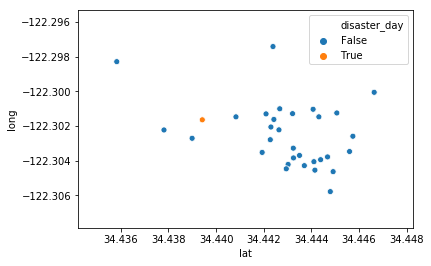

In [385]:
sns.scatterplot(x=napa_2['lat'], y=napa_2['long'], hue=napa_2['disaster_day'])

In [406]:
#sns.scatterplot(x=napa_2['lat'], y=napa_2['long'], hue=napa_2['time'])

In [ ]:
X = np.append(napa_group3['lat'],napa_group3['long']).transpose()

In [415]:
X = Aus1_2[['lat', 'long']]

In [416]:
X = X.as_matrix()

/Users/mattcarney/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [417]:
X.shape

(30, 2)

In [418]:
#helper function that allows us to display data in 2 dimensions an highlights the clusters
def display_cluster(X,km=[],num_clusters=0):
    color = 'brgcmyk'
    alpha = 0.5
    s = 20
    if num_clusters == 0:
        plt.scatter(X[:,0],X[:,1],c = color[0],alpha = alpha,s = s)
    else:
        for i in range(num_clusters):
            plt.scatter(X[km.labels_==i,0],X[km.labels_==i,1],c = color[i],alpha = alpha,s=s)
            plt.scatter(km.cluster_centers_[i][0],km.cluster_centers_[i][1],c = color[i], marker = 'x', s = 100)

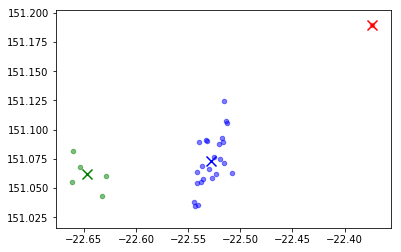

In [422]:
num_clusters = 3
km = KMeans(n_clusters=num_clusters,random_state=10,n_init=1) # n_init, number of times the K-mean algorithm will run
km.fit(X)
display_cluster(X,km,num_clusters)

In [193]:
km.cluster_centers_

array([[  34.41003483, -122.28827043],
       [  34.45623124, -122.32106243],
       [  34.44652537, -122.29392285]])

In [194]:
km.inertia_

11.857639342867303

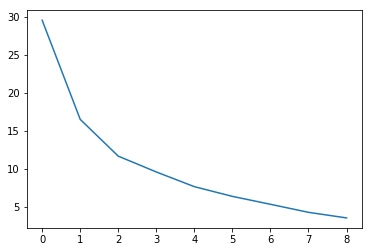

In [195]:
plt.plot([KMeans(n_clusters=i).fit(X).inertia_ for i in range(1,10)])

In [ ]:
#Pickle data
redo_pickle = False
if redo_pickle == True:
    with open('df.pickle','wb') as f:
        pickle.dump(df,f)
#if redo_pickle == False:
    #with open('df.pickle','rb') as f:
        #df = pickle.load(f)

In [ ]:
#Add natural disaster tag
'Wipha' and '2013-10-11', '2013-10-12', '2013-10-13', '2013-10-14', '2013-10-15', '2013-10-16'
#'Halong'
#'Kalmaegi'
'Manila' and '2014-7-11', '2014-7-12', '2014-7-13', '2014-7-14', '2014-7-15', '2014-7-16', '2014-7-17', '2014-7-18'
'Bohol' and '2013-10-15'
'Iquidue'and '2014-04-01'
'Napa' and '2014-08-24
'Norfolk'
'Hamburg'
'Atlanta' '2014-01-28'
'Phoenix': 
'Detroit': '2014-09-20'
'Baltimore': 
'Australia1': 2013-10-17, 2013-10-28
'Australia2': 

    

In [ ]:
#Sort data by time
df_small = df_small.groupby(['event_name', 'user'], group_keys=False)
df_small = df_small.apply(lambda _df_small: _df_small.sort_values(by=['time']))

In [ ]:
#Generate distance between tweets column
df_small['lat_1'] = df_small['lat'].shift()
df_small['long_1'] = df_small['long'].shift()
df_small['dist_mi'] = df_small.apply(lambda row: vincenty((row['lat'], row['long']), (row['lat_1'], row['long_1'])), axis=1)

In [ ]:
#Delete first row in every groupby
df_small = df_small.groupby(['event_name', 'user'], group_keys=False).apply(lambda row: row.iloc[1:])

In [ ]:
#Create tweet velocity column
df_small['time_diff'] = df_small['time'].diff()
df_small['time_diff_hour'] = df_small['time_diff']/np.timedelta64(1, 'h')
df_small['time_diff_day'] = df_small['time_diff']/np.timedelta64(1, 'D')
df_small['velocity_mph'] = df_small['dist_mi']/df_small['time_diff_hour']
df_small['dist_cent'] = df_small.apply(lambda row: vincenty((row['lat'], row['long']), \
                                                    (df_small['lat'].mean(), df_small['long'].mean())), axis=1)